---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiantes: 
-**Erick Muñoz Zamora** **B44810**
-**Bryan Ramírez Ampié**  **B35581**


---

# Determinación teórica

Primero, sabiendo que tenemos el requisito de lograr que no haya nunca 50 o más personas en la cola del proceso de vacunación, entonces con la probabilidad de que este evento suceda se tiene. 



$$P(51\ o\ mas\ clientes\ en\ el\ sistema) = \sum_{i=50}^{\infty} (1-\rho)\rho^i = 1 - \sum_{i=0}^{\infty} (1-\rho)\rho^i = \rho^{51}$$



En nuestro caso, se tiene que la tasa de servicio varía con la cantidad de servidores que se tienen disponibles, $s$ y así sabemos que:



$$ \rho  = \frac{\lambda}{v*s}$$



Sabiendo que para este caso nuestro $\lambda = 4 per/min$ y que $v=0.25per/min$, además sustituyendo en la ecuación inicial:


$$P(Clientes>51) = (\frac{\lambda}{sv}) ^{51} <= \% Error\ deseado$$



En nuestro caso queremos que el sistema no pase de 50 personas más del 5% del tiempo, por lo tanto: 


$$P(Clientes>51) = \frac{\lambda}{sv} ^{51} <= 0.05$$


Finalmente esto nos da que el s debe de ser $s≈16.968$, por lo tanto se necesitan al menos 17 servidores para mantener el sistema funcionando de la forma deseada. 

---

# Comprobación de la determinación teórica

Parámetro lambda = 4.0
Parámetro nu = 0.25
Tiempo con más de 50 solicitudes en fila:
	 0.09%
	 Sí cumple con la especificación.
Simulación es equivalente a 4.49 horas.


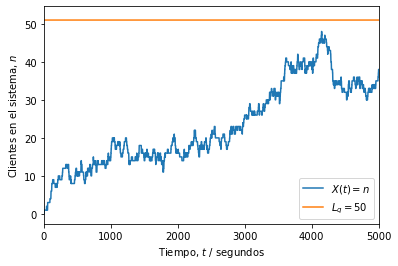

Parámetro lambda = 4.0
Parámetro nu = 0.25
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 4.53 horas.


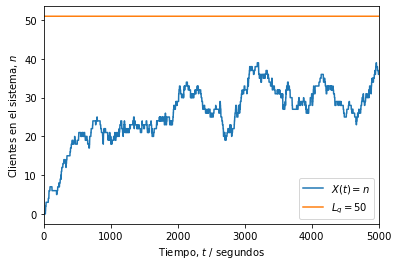

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Se epite dos veces el proceso para obtener 2 gáfics distintas con los mismos parámetros
for i in range(2):
    # Número de clientes
    N = 1000

    # Parámetro de llegada (clientes/segundos)
    lam = 4/60

    # Parámetro de servicio (servicios/segundos)
    nu = 0.25/60

    # Cantidad de servidores
    s = 17

    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale = 1/lam)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale = 1/nu)

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)


    # Vetores con los tiempos de fin de servicio de cada servidor
    servidores = np.zeros(s)


    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    # Inicialización del tiempo de inicio y fin de atención del primer cliente
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida

    # Asignación del primer cliente

    servidores [0] = fin

    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]
    for i in range(1, N):

        # Se buscan sevidores desocupados
        desocupados = 0
        for l, m in enumerate(servidores):
            if m <= t_llegadas[i]:
                desocupados = l
                break
        
        # Se define el tiempo de inicio según si hay o no servidores desocupados
        if desocupados == 0:
            inicio = min(servidores) +1
        else:
            inicio = t_llegadas[i]

        fin = inicio + t_servicio[i]
        minindex = np.argmin(servidores)
        servidores[minindex]=fin

        desocupados = np.where(servidores <= t_llegadas[i])
        inicio = np.max((t_llegadas[i], fin))
        fin = inicio + t_servicio[i]
        t_atencion.append(inicio)

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(int(t_atencion[-1] + t_servicio[-1] + 1))

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    try:
        for c in range(N):
            i = t_llegadas[c]
            t[i] += 1
            j =int(t_atencion[c] + t_servicio[c])
            t[j] -= 1
    except:
        pass

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 52

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        try:
            n += c # sumar (+1) o restar (-1) al estado
            Xt[i] = n
            if Xt[i] >= P: 
                exceso += 1
        except:
            pass

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
    print('\t {:0.2f}%'.format(100*fraccion))
    if fraccion <= 0.01:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.') 
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))


    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, 5000))
    plt.show() 

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---